# Deep Learning Project - VQAExplanable Pt2
**Author: Minyue Jin**

_Inspired by HuggingFace [tutorial](https://huggingface.co/docs/transformers/main/tasks/visual_question_answering) on VQA_

# Overview

The top-down attention mechanism introduced in [this paper](https://openaccess.thecvf.com/content_cvpr_2018/papers/Anderson_Bottom-Up_and_Top-Down_CVPR_2018_paper.pdf) aims to efficiently fuse image features and text features. Another recent and widely adopted technique, Vision-Language Pretraining (VLP) also solves this issue in a different way, by pretraining the image and text encoders on a huge number of image-text pairs, and it's received tremendous success where it advances the performance for many multimodal downstream tasks, including VQA.

In this section, I aim to answer the following questions to compare these two:
1. Which one can better fuse image and text features?
2. Can we combine them to have even better feature fusion?

To do that, I plan to run the following experiments on a [VQA dataset](https://huggingface.co/datasets/HuggingFaceM4/VQAv2), and compare their performance:
1. Finetune a pretrained [BLIP](https://arxiv.org/pdf/2201.12086) model
2. Use the same pretrained BLIP model, add top-down attention, then finetune it
3. Use ImageNet pretrained ViT (the same image encoder used in BLIP) + BERT (base text encoder used in BLIP) + BLIP decoder, and finetune it
4. Use ImageNet pretrained ViT + BERT + BLIP decoder, add top-down attention, then finetune it

Comparing 1 & 2 will help answer question 2; comparing 1 & 3 and 3 & 4 will help answer question 1.

# Setup

## Import dependencies

In [1]:
import itertools
from datasets import load_dataset
import aiohttp

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoProcessor, BlipForQuestionAnswering
from transformers import DefaultDataCollator, TrainingArguments, Trainer

In [3]:
from evaluate import load

In [4]:
from transformers.models.blip.configuration_blip import BlipTextConfig
from transformers.models.blip.modeling_blip import BlipTextVisionModelOutput
from transformers.models.blip.modeling_blip_text import BlipTextLMHeadModel
from typing import Any, Optional, Tuple, Union, Mapping, List, Dict

In [5]:
from transformers import PreTrainedModel, GenerationMixin, PretrainedConfig, AutoConfig, AutoModel, GenerationConfig

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
from transformers.utils import logging
logger = logging.get_logger(__name__)

In [8]:
from tqdm import tqdm

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
import pandas as pd
from tabulate import tabulate

In [11]:
from pytorch_grad_cam import GradCAM, FinerCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import FinerWeightedTarget

## Setup datasets

In order to speed up finetuning, I'm only going to use 10% of the training set, and 1% of the validation set. Since the learning rate will be small, and the training will be short, the risk of overfitting is low.

In [12]:
train_dset = load_dataset(
    "HuggingFaceM4/VQAv2", split="train[:10%]",
    # avoid FSTimeOut, see https://github.com/huggingface/datasets/issues/7175
    storage_options={'client_kwargs': {'timeout': aiohttp.ClientTimeout(total=3600)}}
)

Repo card metadata block was not found. Setting CardData to empty.


In [13]:
len(train_dset)

44376

In [14]:
val_dset = load_dataset(
    "HuggingFaceM4/VQAv2", 
    split="validation[:1%]",
    storage_options={'client_kwargs': {'timeout': aiohttp.ClientTimeout(total=3600)}}
)

Repo card metadata block was not found. Setting CardData to empty.


In [15]:
len(val_dset)

2144

In [16]:
class WrappedVQADataset(torch.utils.data.Dataset):
    """Wrapper around HF VQAv2 dataset."""

    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        encoding = self.processor(
            self.dataset[idx]['image'], 
            self.dataset[idx]['question'], 
            padding="max_length", truncation=True, return_tensors="pt"
        )
        labels = self.processor.tokenizer.encode(
            self.dataset[idx]['multiple_choice_answer'], 
            max_length=8, pad_to_max_length=True, truncation=True, return_tensors='pt'
        )
        encoding["labels"] = labels
        # remove batch dimension
        for k, v in encoding.items():
            encoding[k] = v.squeeze()
        return encoding

In [17]:
data_collator = DefaultDataCollator()

In [18]:
model_checkpoint = "Salesforce/blip-vqa-base"

In [19]:
processor = AutoProcessor.from_pretrained("Salesforce/blip-vqa-base")

In [20]:
train_wrapped = WrappedVQADataset(train_dset, processor)

In [21]:
val_wrapped = WrappedVQADataset(val_dset, processor)

## Custom implementation

### Top-down attention

In [14]:
class TopDownAttention(nn.Module):
    def __init__(self, image_feature_dim=768, question_dim=768, hidden_dim=768):
        super().__init__()
        self.attention_layer = nn.Sequential(
            nn.Linear(image_feature_dim + question_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
        )
    
    def forward(self, img_feats, q_feats):
        padding_size = img_feats.shape[1] - q_feats.shape[1]
        # Pad q_features on the second dimension so it can be concatenated with image_feats
        q_feats_padded = F.pad(q_feats, (0, 0, 0, padding_size, 0, 0), "constant", 0)
        joint_feats = torch.concat([img_feats, q_feats_padded], dim=-1)
        joint_repr = torch.tanh(joint_feats)
        attn_weights = self.attention_layer(joint_repr)
        attn_weights = torch.softmax(attn_weights, dim=1)

        # Weighted sum of image features
        weighted_img_feats = (attn_weights * img_feats).sum(dim=1)
        return weighted_img_feats.unsqueeze(1)

In [15]:
class CustomBlipForQuestionAnswering(BlipForQuestionAnswering):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.top_down_attn = TopDownAttention()
        self.post_init()
        
    def forward(
        self,
        input_ids: torch.LongTensor,
        pixel_values: torch.FloatTensor,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        labels: Optional[torch.LongTensor] = None,
        return_dict: Optional[bool] = None,
        interpolate_pos_encoding: bool = False,
    ) -> Union[Tuple, BlipTextVisionModelOutput]:
        """
        Modified from https://github.com/huggingface/transformers/blob/main/src/transformers/models/blip/modeling_blip.py
        """
        ### START COPY-PASTE ###
        if labels is None and decoder_input_ids is None:
            raise ValueError(
                "Either `decoder_input_ids` or `labels` should be passed when calling `forward` with"
                " `BlipForQuestionAnswering`. if you are training the model make sure that `labels` is passed, if you"
                " are using the model for inference make sure that `decoder_input_ids` is passed or call `generate`"
            )

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )

        vision_outputs = self.vision_model(
            pixel_values=pixel_values,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            interpolate_pos_encoding=interpolate_pos_encoding,
        )

        image_embeds = vision_outputs[0]
        image_attention_mask = torch.ones(image_embeds.size()[:-1], dtype=torch.long)

        question_embeds = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=image_embeds,
            encoder_attention_mask=image_attention_mask,
            return_dict=return_dict,
        )

        if labels is not None and decoder_input_ids is None:
            # labels are already shifted right, see: https://github.com/huggingface/transformers/pull/23153
            decoder_input_ids = labels

        question_embeds = question_embeds[0] if not return_dict else question_embeds.last_hidden_state
        ### END COPY-PASTE ###
        
        # Add top down attention
        image_attn = self.top_down_attn(image_embeds, question_embeds)
        question_embeds = question_embeds * image_attn

        ### START COPY-PASTE ###
        answer_output = self.text_decoder(
            input_ids=decoder_input_ids,
            attention_mask=decoder_attention_mask,
            encoder_hidden_states=question_embeds,
            encoder_attention_mask=attention_mask,
            labels=labels,
            return_dict=return_dict,
            reduction="mean",
        )

        if labels is not None:
            decoder_loss = answer_output.loss.mean() if return_dict else answer_output[0].mean()
        else:
            decoder_loss = None

        if not return_dict:
            outputs = (decoder_loss, image_embeds, vision_outputs[0]) + vision_outputs[2:]
            return tuple(output for output in outputs if output is not None)

        return BlipTextVisionModelOutput(
            loss=decoder_loss,
            image_embeds=image_embeds,
            last_hidden_state=vision_outputs.last_hidden_state,
            hidden_states=vision_outputs.hidden_states,
            attentions=vision_outputs.attentions,
        )

### ViT + BERT

In [16]:
# Developed based on https://github.com/huggingface/transformers/blob/main/src/transformers/models/vision_encoder_decoder/configuration_vision_encoder_decoder.py
class VisionTextEncoderDecoderConfig(PretrainedConfig):
    model_type = "vision-text-encoder-decoder"
    sub_configs = {"vision_encoder": AutoConfig, "text_encoder": AutoConfig, "decoder": AutoConfig}
    has_no_defaults_at_init = True
    
    def __init__(self, use_top_down_attn=False, **kwargs):
        super().__init__(**kwargs)
        # if "vision_encoder" not in kwargs or "text_encoder" not in kwargs or "decoder" not in kwargs:
        #     raise ValueError(
        #         f"A configuraton of type {self.model_type} cannot be instantiated because "
        #         f"not all of `vision_encoder`, `text_encoder`, and `decoder` sub-configurations are passed, but only {kwargs}"
        #     )

        vision_encoder_config = kwargs.pop("vision_encoder", None)
        if vision_encoder_config:
            vision_encoder_model_type = vision_encoder_config.pop("model_type", None)
        text_encoder_config = kwargs.pop("text_encoder", None)
        if text_encoder_config:
            text_encoder_model_type = text_encoder_config.pop("model_type", None)
        decoder_config = kwargs.pop("decoder", None)
        if decoder_config:
            decoder_model_type = decoder_config.pop("model_type", None)

        if vision_encoder_config and vision_encoder_model_type:
            self.vision_encoder = AutoConfig.for_model(vision_encoder_model_type, **vision_encoder_config)
        if text_encoder_config and text_encoder_model_type:
            self.text_encoder = AutoConfig.for_model(text_encoder_model_type, **text_encoder_config)
        if decoder_config and decoder_model_type:
            if decoder_model_type == 'blip_text_model':
                # Load from finetuned checkpoints
                self.decoder = BlipTextConfig(**decoder_config)
            else:
                self.decoder = AutoConfig.for_model(decoder_model_type, **decoder_config).text_config
        self.is_encoder_decoder = True
        
        self.use_top_down_attn = use_top_down_attn

    @classmethod
    def from_encoder_decoder_configs(
        cls, vision_encoder_config: PretrainedConfig, text_encoder_config: PretrainedConfig, 
        decoder_config: PretrainedConfig, **kwargs
    ) -> PretrainedConfig:
        r"""
        Instantiate a [`VisionTextEncoderDecoderConfig`] (or a derived class) from two pre-trained encoder model
        configurations and a decoder model configuration.

        Returns:
            [`VisionTextEncoderDecoderConfig`]: An instance of a configuration object
        """
        logger.info("Setting `config.is_decoder=True` and `config.add_cross_attention=True` for decoder_config")
        decoder_config.is_decoder = True
        decoder_config.add_cross_attention = True

        return cls(vision_encoder=vision_encoder_config.to_dict(), text_encoder=text_encoder_config.to_dict(), decoder=decoder_config.to_dict(), **kwargs)

In [17]:
class AttentionReducer(nn.Module):
    def __init__(self, input_size=577, output_size=512):
        super().__init__()
        self.attention_weights = nn.Parameter(torch.randn(input_size, output_size))
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        attn_scores = self.softmax(self.attention_weights)  # Normalize scores
        reduced_x = torch.matmul(x.permute(0, 2, 1), attn_scores,).permute(0, 2, 1)  
        return reduced_x

In [18]:
# Developed based on https://github.com/huggingface/transformers/blob/main/src/transformers/models/vision_encoder_decoder/modeling_vision_encoder_decoder.py
class VisionTextEncoderDecoderModelForQuestionAnswering(PreTrainedModel, GenerationMixin):
    config_class = VisionTextEncoderDecoderConfig
    base_model_prefix = "vision_text_encoder_decoder"
    main_input_name = "pixel_values"
    supports_gradient_checkpointing = True
    _tied_weights_keys = ["decoder.cls.predictions.decoder.bias"]
    
    def __init__(
        self,
        config: Optional[PretrainedConfig] = None,
        vision_encoder: Optional[PreTrainedModel] = None,
        text_encoder: Optional[PreTrainedModel] = None,
        decoder: Optional[PreTrainedModel] = None,
    ):
        if config is None and (vision_encoder is None or vision_encoder is None or decoder is None):
            raise ValueError("Either a configuration or an encoder and a decoder has to be provided.")
        if config is None:
            config = VisionEncoderDecoderConfig.from_encoder_decoder_configs(vision_encoder.config, text_encoder.config, decoder.config)
        else:
            if not isinstance(config, self.config_class):
                raise ValueError(f"Config: {config} has to be of type {self.config_class}")

        if config.decoder.cross_attention_hidden_size is not None:
            if config.decoder.cross_attention_hidden_size != config.encoder.hidden_size:
                raise ValueError(
                    "If `cross_attention_hidden_size` is specified in the decoder's configuration, it has to be equal"
                    f" to the encoder's `hidden_size`. Got {config.decoder.cross_attention_hidden_size} for"
                    f" `config.decoder.cross_attention_hidden_size` and {config.encoder.hidden_size} for"
                    " `config.encoder.hidden_size`."
                )

        # initialize with config
        # make sure input & output embeddings is not tied
        config.tie_word_embeddings = False
        super().__init__(config)

        if vision_encoder is None:
            vision_encoder = AutoModel.from_config(config.vision_encoder)
            
        if text_encoder is None:
            text_encoder = AutoModel.from_config(config.text_encoder)

        if decoder is None:
            if isinstance(config.decoder, BlipTextConfig):
                decoder_pretrained_config = config.decoder
            else:
                decoder_pretrained_config = config.decoder.text_config
            decoder = BlipTextLMHeadModel(decoder_pretrained_config)

        self.vision_encoder = vision_encoder
        self.text_encoder = text_encoder
        self.decoder = decoder

        if self.vision_encoder.config.to_dict() != self.config.vision_encoder.to_dict():
            logger.warning(
                f"Config of the encoder: {self.vision_encoder.__class__} is overwritten by shared encoder config:"
                f" {self.config.vision_encoder}"
            )
        if self.text_encoder.config.to_dict() != self.config.text_encoder.to_dict():
            logger.warning(
                f"Config of the encoder: {self.text_encoder.__class__} is overwritten by shared encoder config:"
                f" {self.config.text_encoder}"
            )
        if self.decoder.config.to_dict() != self.config.decoder.to_dict():
            logger.warning(
                f"Config of the decoder: {self.decoder.__class__} is overwritten by shared decoder config:"
                f" {self.config.decoder}"
            )

        # make sure that the individual model's config refers to the shared config
        # so that the updates to the config will be synced
        self.config.vision_encoder._attn_implementation = self.vision_encoder.config._attn_implementation
        self.config.text_encoder._attn_implementation = self.text_encoder.config._attn_implementation
        self.config.decoder._attn_implementation = self.decoder.config._attn_implementation
        self.vision_encoder.config = self.config.vision_encoder
        self.text_encoder.config = self.config.text_encoder
        self.decoder.config = self.config.decoder
        
        if self.config.use_top_down_attn:
            self.top_down_attn = TopDownAttention(
                image_feature_dim=self.vision_encoder.config.hidden_size, 
                question_dim=self.text_encoder.config.hidden_size,
                hidden_dim=self.text_encoder.config.hidden_size,
            )
            enc_feat_dim = self.text_encoder.config.hidden_size
        else:
            self.vision_feat_reduction_attn = AttentionReducer()
            enc_feat_dim = self.vision_encoder.config.hidden_size + self.text_encoder.config.hidden_size
            
        # encoder outputs need to be projected to different dimension for decoder
        self.enc_to_dec_proj = nn.Linear(enc_feat_dim, self.decoder.config.hidden_size)
        
        self.decoder_pad_token_id = (
            config.decoder.pad_token_id
            if not hasattr(config, "decoder_pad_token_id")
            else config.decoder_pad_token_id
        )
        self.decoder_start_token_id = (
            config.decoder.bos_token_id
            if not hasattr(config, "decoder_start_token_id")
            else config.decoder_start_token_id
        )
        
    @classmethod
    def from_encoder_decoder_pretrained(
        cls,
        vision_encoder_pretrained_model_name_or_path: Optional[str] = None,
        text_encoder_pretrained_model_name_or_path: Optional[str] = None,
        decoder_pretrained_model_name_or_path: Optional[str] = None,
        *model_args,
        **kwargs,
    ) -> PreTrainedModel:
        """
        Instantiate an encoder and a decoder from one or two base classes of the library from pretrained model
        checkpoints.


        The model is set in evaluation mode by default using `model.eval()` (Dropout modules are deactivated). To train
        the model, you need to first set it back in training mode with `model.train()`.
        """

        kwargs_vision_encoder = {
            argument[len("vision_encoder_") :]: value for argument, value in kwargs.items() if argument.startswith("vision_encoder_")
        }
        
        kwargs_text_encoder = {
            argument[len("text_encoder_") :]: value for argument, value in kwargs.items() if argument.startswith("text_encoder_")
        }

        kwargs_decoder = {
            argument[len("decoder_") :]: value for argument, value in kwargs.items() if argument.startswith("decoder_")
        }

        # remove encoder, decoder kwargs from kwargs
        for key in kwargs_vision_encoder.keys():
            del kwargs["vision_encoder_" + key]
        for key in kwargs_text_encoder.keys():
            del kwargs["text_encoder_" + key]
        for key in kwargs_decoder.keys():
            del kwargs["decoder_" + key]

        # Load and initialize the encoder and decoder
        # The distinction between encoder and decoder at the model level is made
        # by the value of the flag `is_decoder` that we need to set correctly.
        vision_encoder = kwargs_vision_encoder.pop("model", None)
        if vision_encoder is None:
            if vision_encoder_pretrained_model_name_or_path is None:
                raise ValueError(
                    "If `vision_encoder_model` is not defined as an argument, a `vision_encoder_pretrained_model_name_or_path` has "
                    "to be defined."
                )

            if "config" not in kwargs_vision_encoder:
                vision_encoder_config, kwargs_vision_encoder = AutoConfig.from_pretrained(
                    vision_encoder_pretrained_model_name_or_path, **kwargs_vision_encoder, return_unused_kwargs=True
                )

                if vision_encoder_config.is_decoder is True or vision_encoder_config.add_cross_attention is True:
                    logger.info(
                        f"Initializing {vision_encoder_pretrained_model_name_or_path} as a encoder model "
                        "from a decoder model. Cross-attention and casual mask are disabled."
                    )
                    vision_encoder_config.is_decoder = False
                    vision_encoder_config.add_cross_attention = False

                kwargs_vision_encoder["config"] = vision_encoder_config

            vision_encoder = AutoModel.from_pretrained(vision_encoder_pretrained_model_name_or_path, *model_args, **kwargs_vision_encoder)
        
        text_encoder = kwargs_text_encoder.pop("model", None)
        if text_encoder is None:
            if text_encoder_pretrained_model_name_or_path is None:
                raise ValueError(
                    "If `text_encoder_model` is not defined as an argument, a `text_encoder_pretrained_model_name_or_path` has "
                    "to be defined."
                )

            if "config" not in kwargs_text_encoder:
                text_encoder_config, kwargs_text_encoder = AutoConfig.from_pretrained(
                    text_encoder_pretrained_model_name_or_path, **kwargs_text_encoder, return_unused_kwargs=True
                )

                if text_encoder_config.is_decoder is True or text_encoder_config.add_cross_attention is True:
                    logger.info(
                        f"Initializing {text_encoder_pretrained_model_name_or_path} as a encoder model "
                        "from a decoder model. Cross-attention and casual mask are disabled."
                    )
                    text_encoder_config.is_decoder = False
                    text_encoder_config.add_cross_attention = False

                kwargs_text_encoder["config"] = text_encoder_config

            text_encoder = AutoModel.from_pretrained(text_encoder_pretrained_model_name_or_path, *model_args, **kwargs_text_encoder)

        decoder = kwargs_decoder.pop("model", None)
        if decoder is None:
            if decoder_pretrained_model_name_or_path is None:
                raise ValueError(
                    "If `decoder_model` is not defined as an argument, a `decoder_pretrained_model_name_or_path` has "
                    "to be defined."
                )

            if "config" not in kwargs_decoder:
                decoder_config, kwargs_decoder = AutoConfig.from_pretrained(
                    decoder_pretrained_model_name_or_path, **kwargs_decoder, return_unused_kwargs=True
                )

                if decoder_config.is_decoder is False or decoder_config.add_cross_attention is False:
                    logger.info(
                        f"Initializing {decoder_pretrained_model_name_or_path} as a decoder model. Cross attention"
                        f" layers are added to {decoder_pretrained_model_name_or_path} and randomly initialized if"
                        f" {decoder_pretrained_model_name_or_path}'s architecture allows for cross attention layers."
                    )
                    decoder_config.is_decoder = True
                    decoder_config.add_cross_attention = True

                kwargs_decoder["config"] = decoder_config

            if kwargs_decoder["config"].is_decoder is False or kwargs_decoder["config"].add_cross_attention is False:
                logger.warning(
                    f"Decoder model {decoder_pretrained_model_name_or_path} is not initialized as a decoder. "
                    f"In order to initialize {decoder_pretrained_model_name_or_path} as a decoder, "
                    "make sure that the attributes `is_decoder` and `add_cross_attention` of `decoder_config` "
                    "passed to `.from_encoder_decoder_pretrained(...)` are set to `True` or do not pass a "
                    "`decoder_config` to `.from_encoder_decoder_pretrained(...)`"
                )

            decoder = BlipForQuestionAnswering.from_pretrained(decoder_pretrained_model_name_or_path, **kwargs_decoder)

        # instantiate config with corresponding kwargs
        config = VisionTextEncoderDecoderConfig.from_encoder_decoder_configs(vision_encoder.config, text_encoder.config, decoder.config, **kwargs)
        decoder = decoder.text_decoder

        # make sure input & output embeddings is not tied
        config.tie_word_embeddings = False
        return cls(vision_encoder=vision_encoder, text_encoder=text_encoder, decoder=decoder, config=config)
    
    def forward(
        self,
        input_ids: torch.LongTensor,
        pixel_values: torch.FloatTensor,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        labels: Optional[torch.LongTensor] = None,
        return_dict: Optional[bool] = None,
        interpolate_pos_encoding: bool = False,
        **kwargs,
    ) -> Union[Tuple[torch.FloatTensor], BlipTextVisionModelOutput]:
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # num_items_in_batch is only needed for loss computation
        num_items_in_batch = kwargs.pop("num_items_in_batch", None)

        kwargs_vision_encoder = {argument: value for argument, value in kwargs.items() if argument.startswith("vision_encoder_")}
        kwargs_text_encoder = {argument: value for argument, value in kwargs.items() if argument.startswith("text_encoder_")}

        kwargs_decoder = {
            argument[len("decoder_") :]: value for argument, value in kwargs.items() if argument.startswith("decoder_")
        }

        vision_encoder_outputs = self.vision_encoder(
            pixel_values=pixel_values,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            **kwargs_vision_encoder,
        )
        text_encoder_outputs = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            **kwargs_text_encoder,
        )
            
        vision_encoder_hidden_states = vision_encoder_outputs[0]
        text_encoder_hidden_states = text_encoder_outputs[0]
        if self.config.use_top_down_attn:
            image_attn = self.top_down_attn(vision_encoder_hidden_states, text_encoder_hidden_states)
            encoder_hidden_states = text_encoder_hidden_states * image_attn
        else:
            vision_encoder_hidden_states_proj = self.vision_feat_reduction_attn(vision_encoder_hidden_states)
            encoder_hidden_states = torch.concat([vision_encoder_hidden_states_proj, text_encoder_hidden_states], dim=-1)

        encoder_hidden_states = self.enc_to_dec_proj(encoder_hidden_states)

        # else:
        encoder_attention_mask = None

        if labels is not None and decoder_input_ids is None:
            # labels are already shifted right, see: https://github.com/huggingface/transformers/pull/23153
            decoder_input_ids = labels

        # Decode
        answer_output = self.decoder(
            input_ids=decoder_input_ids,
            attention_mask=decoder_attention_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=attention_mask,
            labels=labels,
            return_dict=return_dict,
            reduction="mean",
        )

        if labels is not None:
            loss = answer_output.loss.mean() if return_dict else answer_output[0].mean()
        else:
            loss = None

        if not return_dict:
            if loss is not None:
                return (loss,) + answer_output + vision_encoder_outputs + text_encoder_outputs
            else:
                return answer_output + vision_encoder_outputs + text_encoder_outputs

        return BlipTextVisionModelOutput(
            loss=loss,
            image_embeds=vision_encoder_hidden_states,
            last_hidden_state=vision_encoder_hidden_states,
            hidden_states=vision_encoder_outputs.hidden_states,
            attentions=vision_encoder_outputs.attentions,
        )
    
    @torch.no_grad()
    def generate(
        self,
        input_ids: torch.LongTensor,
        pixel_values: torch.FloatTensor,
        attention_mask: Optional[torch.LongTensor] = None,
        interpolate_pos_encoding: bool = False,
        **generate_kwargs,
    ) -> torch.LongTensor:
        """
        Overrides *generate* function to be able to use the model as a conditional generator

        Parameters:
            input_ids (*torch.LongTensor* of shape *(batch_size, sequence_length)*):
                The sequence used as a prompt for the generation.
            pixel_values (*torch.FloatTensor* of shape *(batch_size, num_channels, image_height, image_width)*:
                Input image to be processed
            attention_mask (*torch.LongTensor* of shape *(batch_size, sequence_length)*, *optional*):
                Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`. `1` for
                tokens that are NOT MASKED, `0` for MASKED tokens.
            **generate_kwargs:
                Additional arguments passed to the *generate* function of the decoder
        """
        vision_outputs = self.vision_encoder(
            pixel_values=pixel_values,
            interpolate_pos_encoding=interpolate_pos_encoding,
        )

        image_embeds = vision_outputs[0]

        image_attention_mask = torch.ones(image_embeds.size()[:-1], dtype=torch.long, device=image_embeds.device)

        if isinstance(input_ids, list):
            input_ids = torch.LongTensor(input_ids)

        question_outputs = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False,
        )

        question_embeds = question_outputs[0]
        
        if self.config.use_top_down_attn:
            image_attn = self.top_down_attn(image_embeds, question_embeds)
            question_embeds = question_embeds * image_attn
        else:
            image_embeds_proj = self.vision_feat_reduction_attn(image_embeds)
            question_embeds = torch.concat([image_embeds_proj, question_embeds], dim=-1)

        question_embeds = self.enc_to_dec_proj(question_embeds)

        question_attention_mask = torch.ones(
            question_embeds.size()[:-1], dtype=torch.long, device=question_embeds.device
        )

        bos_ids = torch.full(
            (question_embeds.size(0), 1), fill_value=self.decoder_start_token_id, device=question_embeds.device
        )

        outputs = self.decoder.generate(
            input_ids=bos_ids,
            eos_token_id=self.config.decoder.sep_token_id,
            pad_token_id=self.config.decoder.pad_token_id,
            encoder_hidden_states=question_embeds,
            encoder_attention_mask=question_attention_mask,
            **generate_kwargs,
        )

        return outputs


# Experiments

## Experiment 1. Finetune pretrained BLIP

In [22]:
model = BlipForQuestionAnswering.from_pretrained(model_checkpoint)

In [23]:
training_args = TrainingArguments(
    output_dir='./ckpt-exp1',
    per_device_train_batch_size=12,
    dataloader_num_workers=12,
    # num_train_epochs=2,
    max_steps=7500,
    save_steps=500,
    logging_steps=50,
    eval_strategy='steps',
    eval_steps=500,
    learning_rate=2e-5,
    save_total_limit=2,
    remove_unused_columns=True,
    push_to_hub=False,
    load_best_model_at_end=True,
    report_to="none",
)

In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_wrapped,
    eval_dataset=val_wrapped,
    processing_class=processor,
)

[2025-04-24 20:09:52,483] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/ray/anaconda3/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/ray/anaconda3/compiler_compat/ld: warning: libpthread.so.0, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/ray/anaconda3/compiler_compat/ld: warning: libstdc++.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/ray/anaconda3/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/ray/anaconda3/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::runtime_error::~runtime_error()@GLIBCXX_3.4'
/home/ray/anaconda3/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `__gxx_personality_v0@CXXABI_1.3'
/home/ray/anaconda3/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::ostream::tellp()@GLIBCX

In [25]:
trainer.train()

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Step,Training Loss,Validation Loss
500,0.213300,0.190690
1000,0.179700,0.188632
1500,0.219100,0.181122
2000,0.185600,0.174907
2500,0.196500,0.172125
3000,0.187800,0.171344
3500,0.184700,0.167277
4000,0.084800,0.174912
4500,0.090000,0.168483
5000,0.103200,0.174329


There were missing keys in the checkpoint model loaded: ['text_decoder.cls.predictions.decoder.bias'].


TrainOutput(global_step=7500, training_loss=0.26640469783147175, metrics={'train_runtime': 15355.6321, 'train_samples_per_second': 5.861, 'train_steps_per_second': 0.488, 'total_flos': 9.317411278848e+16, 'train_loss': 0.26640469783147175, 'epoch': 2.0281233098972415})

In [26]:
del model
del trainer
torch.cuda.empty_cache()

## Experiment 2. Finetune BLIP + top-down attention

In [16]:
pretrained_model = BlipForQuestionAnswering.from_pretrained(model_checkpoint)

In [17]:
blip_top_down_attn = CustomBlipForQuestionAnswering(pretrained_model.config)

In [18]:
blip_top_down_attn.load_state_dict(pretrained_model.state_dict(), strict=False)  # Load weights

_IncompatibleKeys(missing_keys=['top_down_attn.attention_layer.0.weight', 'top_down_attn.attention_layer.0.bias', 'top_down_attn.attention_layer.1.weight', 'top_down_attn.attention_layer.1.bias'], unexpected_keys=[])

In [19]:
del pretrained_model
torch.cuda.empty_cache()

In [20]:
training_args = TrainingArguments(
    output_dir='./ckpt-exp2',
    per_device_train_batch_size=12,
    dataloader_num_workers=12,
    # num_train_epochs=2,
    max_steps=7500,
    save_steps=500,
    logging_steps=50,
    eval_strategy='steps',
    eval_steps=500,
    learning_rate=2e-5,
    save_total_limit=2,
    remove_unused_columns=True,
    push_to_hub=False,
    load_best_model_at_end=True,
    report_to="none",
)

In [21]:
trainer = Trainer(
    model=blip_top_down_attn,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_wrapped,
    eval_dataset=val_wrapped,
    processing_class=processor,
)

[2025-04-23 08:02:05,700] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/ray/anaconda3/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/ray/anaconda3/compiler_compat/ld: warning: libpthread.so.0, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/ray/anaconda3/compiler_compat/ld: warning: libstdc++.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/ray/anaconda3/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/ray/anaconda3/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::runtime_error::~runtime_error()@GLIBCXX_3.4'
/home/ray/anaconda3/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `__gxx_personality_v0@CXXABI_1.3'
/home/ray/anaconda3/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::ostream::tellp()@GLIBCX

In [22]:
trainer.train()

/home/ray/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate exa

Step,Training Loss,Validation Loss
500,0.285800,0.250734
1000,0.203700,0.218200
1500,0.242100,0.199658
2000,0.200400,0.200328
2500,0.207600,0.184504
3000,0.200700,0.186701
3500,0.197000,0.179315
4000,0.097900,0.186822
4500,0.103500,0.174211
5000,0.105600,0.178650


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/ray/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, ple

TrainOutput(global_step=7500, training_loss=0.31387046438852945, metrics={'train_runtime': 15956.1163, 'train_samples_per_second': 5.64, 'train_steps_per_second': 0.47, 'total_flos': 9.366376108032e+16, 'train_loss': 0.31387046438852945, 'epoch': 2.0281233098972415})

In [23]:
del blip_top_down_attn
del trainer
torch.cuda.empty_cache()

## Experiment 3. Finetune ViT + BERT + BLIP decoder

In [22]:
model = VisionTextEncoderDecoderModelForQuestionAnswering.from_encoder_decoder_pretrained(
    "google/vit-base-patch16-384", "google-bert/bert-base-uncased", model_checkpoint
)
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-384 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
training_args = TrainingArguments(
    output_dir='./ckpt-exp3',
    per_device_train_batch_size=12,
    dataloader_num_workers=12,
    # num_train_epochs=2,
    max_steps=7500,
    save_steps=500,
    logging_steps=50,
    eval_strategy='steps',
    eval_steps=500,
    learning_rate=2e-5,
    save_total_limit=2,
    remove_unused_columns=True,
    push_to_hub=False,
    load_best_model_at_end=True,
    report_to="none",
)

In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_wrapped,
    eval_dataset=val_wrapped,
    processing_class=processor,
)

[2025-04-23 20:31:56,468] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/ray/anaconda3/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/ray/anaconda3/compiler_compat/ld: warning: libpthread.so.0, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/ray/anaconda3/compiler_compat/ld: warning: libstdc++.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/ray/anaconda3/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/ray/anaconda3/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::runtime_error::~runtime_error()@GLIBCXX_3.4'
/home/ray/anaconda3/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `__gxx_personality_v0@CXXABI_1.3'
/home/ray/anaconda3/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::ostream::tellp()@GLIBCX

In [25]:
trainer.train()

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Step,Training Loss,Validation Loss
500,0.588400,0.509662
1000,0.442400,0.450919
1500,0.474600,0.424438
2000,0.393100,0.394656
2500,0.430300,0.383725
3000,0.390100,0.372361
3500,0.388700,0.364684
4000,0.278500,0.363574
4500,0.284100,0.359079
5000,0.297700,0.353870


There were missing keys in the checkpoint model loaded: ['decoder.cls.predictions.decoder.bias'].


TrainOutput(global_step=7500, training_loss=0.47820610466003416, metrics={'train_runtime': 10354.3241, 'train_samples_per_second': 8.692, 'train_steps_per_second': 0.724, 'total_flos': 7.436090360070144e+19, 'train_loss': 0.47820610466003416, 'epoch': 2.0281233098972415})

In [26]:
del model
del trainer
torch.cuda.empty_cache()

## Experiment 4. Finetune ViT + BERT + top-down attention + BLIP decoder

In [22]:
model = VisionTextEncoderDecoderModelForQuestionAnswering.from_encoder_decoder_pretrained(
    "google/vit-base-patch16-384", "google-bert/bert-base-uncased", model_checkpoint, use_top_down_attn=True,
)
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-384 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
training_args = TrainingArguments(
    output_dir='./ckpt-exp4',
    per_device_train_batch_size=12,
    dataloader_num_workers=12,
    # num_train_epochs=2,
    max_steps=7500,
    save_steps=500,
    logging_steps=50,
    eval_strategy='steps',
    eval_steps=500,
    learning_rate=2e-5,
    save_total_limit=2,
    remove_unused_columns=True,
    push_to_hub=False,
    load_best_model_at_end=True,
    report_to="none",
)

In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_wrapped,
    eval_dataset=val_wrapped,
    processing_class=processor,
)

[2025-04-24 09:25:14,874] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/ray/anaconda3/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/ray/anaconda3/compiler_compat/ld: warning: libpthread.so.0, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/ray/anaconda3/compiler_compat/ld: warning: libstdc++.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/ray/anaconda3/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/ray/anaconda3/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::runtime_error::~runtime_error()@GLIBCXX_3.4'
/home/ray/anaconda3/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `__gxx_personality_v0@CXXABI_1.3'
/home/ray/anaconda3/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::ostream::tellp()@GLIBCX

In [25]:
trainer.train()

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Step,Training Loss,Validation Loss
500,0.570200,0.500403
1000,0.441900,0.446343
1500,0.467500,0.420005
2000,0.388400,0.400496
2500,0.429500,0.389973
3000,0.396000,0.378734
3500,0.389600,0.370872
4000,0.277600,0.368733
4500,0.283500,0.364590
5000,0.292900,0.363969


There were missing keys in the checkpoint model loaded: ['decoder.cls.predictions.decoder.bias'].


TrainOutput(global_step=7500, training_loss=0.48927564315795896, metrics={'train_runtime': 10648.1994, 'train_samples_per_second': 8.452, 'train_steps_per_second': 0.704, 'total_flos': 7.457249281572864e+19, 'train_loss': 0.48927564315795896, 'epoch': 2.0281233098972415})

In [ ]:
del model
del trainer
torch.cuda.empty_cache()

# Evaluation

## Validation loss

All 4 models are evaluated on the same validation dataset split during training, so we can use validation loss to evaluate their performance

In [26]:
steps = np.arange(500, 8000, 500)
blip = [0.190690, 0.188632, 0.181122, 0.174907, 0.172125, 0.171344, 0.167277, 0.174912, 0.168483, 0.174329, 0.170734, 0.162527, 0.164866, 0.158236, 0.157603]
blip_tda = [0.250734, 0.218200, 0.199658, 0.200328, 0.184504, 0.186701, 0.179315, 0.186822, 0.174211, 0.178650, 0.182654, 0.172053, 0.171292, 0.165728, 0.165230]
vit_bert = [0.509662, 0.450919, 0.424438, 0.394656, 0.383725, 0.372361, 0.364684, 0.363574, 0.359079, 0.353870, 0.354201, 0.350843, 0.346748, 0.343687, 0.342804]
vit_bert_tda = [0.500403, 0.446343, 0.420005, 0.400496, 0.389973, 0.378734, 0.370872, 0.368733, 0.364590, 0.363969, 0.363603, 0.359058, 0.356666, 0.353539, 0.353495]

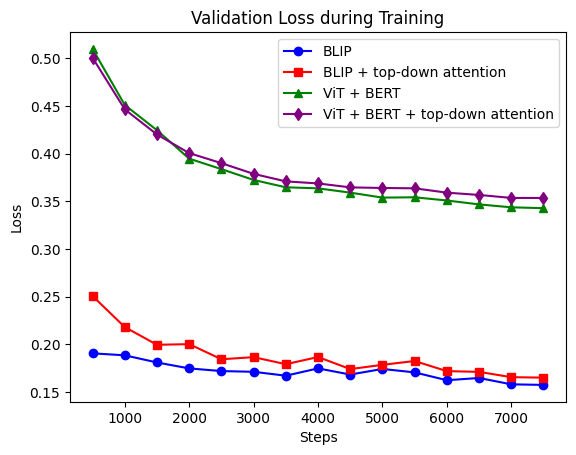

In [27]:
plt.plot(steps, blip, label="BLIP", marker="o", color="blue")
plt.plot(steps, blip_tda, label="BLIP + top-down attention", marker="s", color="red")
plt.plot(steps, vit_bert, label="ViT + BERT", marker="^", color="green")
plt.plot(steps, vit_bert_tda, label="ViT + BERT + top-down attention", marker="d", color="purple")

plt.title("Validation Loss during Training")
plt.xlabel("Steps")
plt.ylabel("Loss")

plt.legend()
plt.show()

It's clear that vanilla BLIP has the best performance because it's the first to converge, and it converges to a lower validation loss. Among the rest, BLIP with top down attention converges at a pace only a little slower than vanilla BLIP, and reaches a slightly higher loss in the end. The ViT + BERT + BLIP decoder model has worse performance, where it converges the most slowly, and reaches higher loss in the end. The ViT + BERT + top-down attention + BLIP decoder model converges faster than its counterpart without top-down attention, but arrives at the highest loss in the end.

By looking at the plots, I have the following findings:
- Adding top-down attention will help vision and text encoders initially, when they are not pretrained by VLP, but may lead to slower convergence
- Adding top-down attention will not help vision and text encoders pretrained by VLP, and at the same time it will slow down convergence
- VLP pretrained vision and text encoders perform better than separately pretrained ones plus top-down attention

## VQA accuracy metrics

Although validation losses tell a good story, it's better to compute some metrics on a completely unseen dataset to gather more information.

To do that, I choose to run [VQA accuracy](https://arxiv.org/pdf/1505.00468) on 1000 examples of the val split of the VQAv2 dataset. This split doesn't overlap with the one used during training.

### Setup metrics

In [19]:
test_dset = load_dataset(
    "HuggingFaceM4/VQAv2", 
    split="validation[-1000:]",
    storage_options={'client_kwargs': {'timeout': aiohttp.ClientTimeout(total=3600)}}
)

Repo card metadata block was not found. Setting CardData to empty.


In [20]:
len(test_dset)

1000

In [27]:
vqa_accuracy = load("Kamichanw/vqa_accuracy")

In [38]:
def prepare_input(data, device):
    if isinstance(data, Mapping):
        return type(data)({k: prepare_input(v, device) for k, v in data.items()})
    elif isinstance(data, (tuple, list)):
        return type(data)(prepare_input(v, device) for v in data)
    elif isinstance(data, torch.Tensor):
        return data.to(device)
    return data

In [54]:
def test_model(model):
    refs = []
    label_ids = []
    preds = []
    question_types = []
    answer_types = []
    for example in tqdm(test_dset):
        inputs = processor(images=example['image'], text=example['question'], padding="max_length", truncation=True, return_tensors="pt")
        label = processor(text=example['multiple_choice_answer'], return_tensors="pt").input_ids
        output = model.generate(**prepare_input(inputs, 'cuda:0'))
        pred = processor.decode(output[0], skip_special_tokens=True)
        refs.append([ans['answer'] for ans in example['answers']])
        label_ids.append(label)
        preds.append(pred)
        question_types.append(example['question_type'])
        answer_types.append(example['answer_type'])
    return refs, label_ids, preds, question_types, answer_types

In [40]:
def compute_vqa_accuracy(model):
    model.eval()
    model.cuda()
    with torch.no_grad():
        refs, label_ids, preds, question_types, answer_types = test_model(model)
    results = vqa_accuracy.compute(predictions=preds, references=refs, question_types=question_types, answer_types=answer_types)
    return results, refs, label_ids, preds

### Load model checkpoints

In [21]:
blip = BlipForQuestionAnswering.from_pretrained('./ckpt-exp1/checkpoint-7500')
blip_tda = CustomBlipForQuestionAnswering.from_pretrained('./ckpt-exp2/checkpoint-7500')
vit_bert = VisionTextEncoderDecoderModelForQuestionAnswering.from_pretrained('./ckpt-exp3/checkpoint-7500')
vit_bert_tda = VisionTextEncoderDecoderModelForQuestionAnswering.from_pretrained('./ckpt-exp4/checkpoint-7500')

### Run metrics

In [38]:
blip_results, blip_refs, blip_label_ids, blip_preds = compute_vqa_accuracy(blip)

100%|██████████| 1000/1000 [11:40<00:00,  1.43it/s]


In [47]:
blip_tda_results, blip_tda_refs, blip_tda_label_ids, blip_tda_preds = compute_vqa_accuracy(blip_tda)

100%|██████████| 1000/1000 [01:06<00:00, 15.04it/s]


In [65]:
vit_bert_results, vit_bert_refs, vit_bert_label_ids, vit_bert_preds = compute_vqa_accuracy(vit_bert)

100%|██████████| 1000/1000 [01:03<00:00, 15.70it/s]


In [66]:
vit_bert_tda_results, vit_bert_tda_refs, vit_bert_tda_label_ids, vit_bert_tda_preds = compute_vqa_accuracy(vit_bert_tda)

100%|██████████| 1000/1000 [01:06<00:00, 14.94it/s]


In [71]:
def flatten_dict(d):
    flat_dict = d.copy()
    for key, sub_dict in d.items():
        if isinstance(sub_dict, dict):
            for sub_key, value in sub_dict.items():
                flat_dict[f"{key}_{sub_key}"] = value  # Create new key format: "ParentKey_SubKey"
            del flat_dict[key]  # Remove original nested dictionary
    return flat_dict

In [75]:
data = [flatten_dict(d) for d in [blip_results, blip_tda_results, vit_bert_results, vit_bert_tda_results]]
df = pd.DataFrame(data)
df.index = ['BLIP', 'BLIP + top-down attention', 'ViT + BERT', 'ViT + BERT + top-down attention']
display(df)

,overall,perAnswerType_yes/no,perAnswerType_number,perAnswerType_other,perQuestionType_is the,perQuestionType_how many,perQuestionType_what is the person,perQuestionType_what,perQuestionType_what color are the,perQuestionType_is there,...,perQuestionType_are these,perQuestionType_who is,perQuestionType_could,perQuestionType_what is the color of the,perQuestionType_has,perQuestionType_is this an,perQuestionType_is that a,perQuestionType_what brand,perQuestionType_is this person,perQuestionType_do you
BLIP,78.68,95.994318,67.317073,69.733333,93.086420,75.274725,60.000000,65.945946,85.789474,92.380952,...,100.00,100.000000,100.000000,100.0,100.0,100.0,100.0,50.0,100.0,100.0
BLIP + top-down attention,77.29,95.085227,64.796748,68.285714,91.481481,69.560440,64.285714,66.081081,80.526316,96.190476,...,100.00,100.000000,96.666667,100.0,100.0,100.0,100.0,50.0,100.0,100.0
ViT + BERT,44.45,69.687500,30.894309,30.704762,72.716049,34.285714,18.571429,30.810811,55.789474,70.000000,...,100.00,10.000000,63.333333,32.5,0.0,82.5,100.0,0.0,100.0,0.0
ViT + BERT + top-down attention,40.29,66.107955,31.382114,25.066667,60.864198,35.604396,32.857143,22.702703,18.947368,73.333333,...,78.75,33.333333,100.000000,47.5,50.0,75.0,0.0,0.0,100.0,100.0


The metrics mostly align with the findings from the validation loss.

# Conclusions

Based on the findings in evaluation, I'm able to draw the following preliminary conclusions:
- VLP is more effective in terms of aggregating vision and text features.
  - The best performing model BLIP has two ways of VLP, **Multimodal Mixture of Encoder-Decoder (MED)** and **Captioning and Filtering (CapFilt)**
  - CapFilt is designed to effectively utilize noisy web data, which can train the vision and text encoder, as well as the decoder, to encode and decode paired vision and text features, and the authors conduct ablation studies to demonstrate its effectiveness. 
  - MED directly couples vision features into text encoder, so that the text encoder will extract text features under the guidance of the vision features. The authors don't conduct ablation studies to explicitly demonstrate its effectiveness, but by comparing the vanilla BLIP and ViT + BERT + BLIP decoder, we can see how MED helps
- Top-down attention can help when vision and text encoders are not trained with VLP, but it's only helpful in early training stages, and may result in slower convergence
  - The top-down attention mechanism may help fuse the vision and text feataures, which can result in better feature extraction during early stages
  - But this extra component will introduce more parameters to the network, which will require longer training to converge
- Adding top-down attention will not help when vision and text encoders are trained with VLP, and at the same time it will slow down convergence
